In [21]:
import json
import re
from os.path import join
import os

import pandas as pd
import numpy as np
from tqdm import tqdm
import xgboost as xgb
from sklearn.model_selection import train_test_split
import optuna
from sklearn.metrics import log_loss
import shap
import matplotlib.pyplot as plt
import seaborn as sns
import matplotlib as mpl

import cfbd

pd.set_option('display.max_columns', None)
pd.set_option('display.max_rows', None)

with open('../config.json') as f:
    configuration = cfbd.Configuration(
        access_token = json.load(f)['CFBD_API_KEY']
    )

## 1. Load the Data

In [22]:
YEARS = range(2013, 2025)
DATA_DIR = '../data'

In [23]:
def convert_to_snake_case(cols):
    cols_new = []
    for c in cols:
        s1 = re.sub('(.)([A-Z][a-z]+)', r'\1_\2', c)
        cols_new.append(re.sub('([a-z0-9])([A-Z])', r'\1_\2', s1).lower())
    return cols_new

In [24]:
# Load games data
all_dfs = []
id_cols = ['id', 'season', 'week', 'season_type', 'completed', 'neutral_site', 'venue_id']
home_cols = ['home_id', 'home_team', 'home_conference', 'home_division', 'home_points', 'home_pregame_elo']
away_cols = ['away_id', 'away_team', 'away_conference', 'away_division', 'away_points', 'away_pregame_elo']

games_dir = join(DATA_DIR, 'games')
if not os.path.exists(games_dir):
    os.makedirs(games_dir)


for year in YEARS:
    file_path = join(games_dir, f'{year}.parquet')
    if os.path.exists(file_path):
        print(f'Reading {file_path} from cached data')
        tmp = pd.read_parquet(file_path)
    else:
        print(f'Fetching {year} games data from CFBD API')
        with cfbd.ApiClient(configuration) as api_client:
            api_instance = cfbd.GamesApi(api_client)
            data = api_instance.get_games(year=year)
        tmp = pd.DataFrame([val.to_dict() for val in data])
        tmp.columns = convert_to_snake_case(tmp.columns)
        tmp = tmp[id_cols + [
                            'home_id','home_team','home_conference','home_classification','home_points','home_pregame_elo',
                            'away_id','away_team','away_conference','away_classification','away_points','away_pregame_elo']]
        tmp['season_type'] = tmp['season_type'].apply(lambda x: x.value)
        tmp = tmp.assign(
            home_division=tmp['home_classification'].apply(lambda x: x.value if x is not None else None),
            away_division=tmp['away_classification'].apply(lambda x: x.value if x is not None else None)
        ).drop(columns=['home_classification','away_classification'])
        tmp = tmp[id_cols + home_cols + away_cols]
        tmp.to_parquet(file_path)
    all_dfs.append(tmp)
del tmp

games = pd.concat(all_dfs, ignore_index=True).reset_index(drop=True)
games.head()

Reading ../data/games/2013.parquet from cached data
Reading ../data/games/2014.parquet from cached data
Reading ../data/games/2015.parquet from cached data
Reading ../data/games/2016.parquet from cached data
Reading ../data/games/2017.parquet from cached data
Reading ../data/games/2018.parquet from cached data
Reading ../data/games/2019.parquet from cached data
Reading ../data/games/2020.parquet from cached data
Reading ../data/games/2021.parquet from cached data
Reading ../data/games/2022.parquet from cached data
Reading ../data/games/2023.parquet from cached data
Reading ../data/games/2024.parquet from cached data


,id,season,week,season_type,completed,neutral_site,venue_id,start_date,home_id,home_team,home_conference,home_points,home_pregame_elo,away_id,away_team,away_conference,away_points,away_pregame_elo,home_division,away_division
0,332412309,2013,1,regular,True,False,3696.0,2013-08-29 22:00:00+00:00,2309,Kent State,Mid-American,17.0,1530.0,2335,Liberty,Big South,10.0,1467.0,fbs,fcs
1,332412579,2013,1,regular,True,False,3994.0,2013-08-29 22:00:00+00:00,2579,South Carolina,SEC,27.0,1759.0,153,North Carolina,ACC,10.0,1638.0,fbs,fbs
2,332410154,2013,1,regular,True,False,3630.0,2013-08-29 22:30:00+00:00,154,Wake Forest,ACC,31.0,NaN,2506,Presbyterian,Big South,7.0,NaN,fbs,fcs
3,332410084,2013,1,regular,True,False,3830.0,2013-08-29 23:00:00+00:00,84,Indiana,Big Ten,73.0,NaN,282,Indiana State,MVFC,35.0,NaN,fbs,fcs
4,332412413,2013,1,regular,True,False,3774.0,2013-08-29 23:00:00+00:00,2413,Morehead State,Pioneer,10.0,NaN,95,Pikeville,None,13.0,NaN,fcs,None


In [25]:
# Load plays data
all_dfs = []
cols = ['id', 'drive_id', 'game_id', 'drive_number', 'play_number', 'offense',
       'offense_conference', 'offense_score', 'defense', 'home', 'away',
       'defense_conference', 'defense_score', 'period', 'offense_timeouts',
       'defense_timeouts', 'yardline', 'yards_to_goal', 'down', 'distance',
       'yards_gained', 'scoring', 'play_type', 'play_text', 'ppa',
       'clock_minutes', 'clock_seconds']

plays_dir = join(DATA_DIR, 'plays')
if not os.path.exists(plays_dir):
    os.makedirs(plays_dir)

for year in YEARS:
    season_file_path = join(plays_dir, f'{year}.parquet')
    
    if os.path.exists(season_file_path):
        print(f'Reading {season_file_path} from cached data')
        season_plays = pd.read_parquet(season_file_path)
    else:
        print(f'Fetching all weeks plays data for {year} from CFBD API')
        weeks = games.query('season == @year').week.unique().tolist()

        season_dfs = []
        for week in weeks:
            print(f'Fetching {year} plays data for week {week} from CFBD API')
            with cfbd.ApiClient(configuration) as api_client:
                api_instance = cfbd.PlaysApi(api_client)
                data = api_instance.get_plays(year=year, week=week)
            tmp = pd.DataFrame([val.to_dict() for val in data])
            if tmp.empty:
                print(f'No plays data for {year} week {week}')
                continue
            tmp.columns = convert_to_snake_case(tmp.columns)

            tmp['clock_minutes'] = tmp['clock'].apply(lambda x: x['minutes'])
            tmp['clock_seconds'] = tmp['clock'].apply(lambda x: x['seconds'])
            tmp.drop(columns=['clock'], inplace=True)

            tmp = tmp[cols]
            season_dfs.append(tmp)
        
        season_plays = pd.concat(season_dfs, ignore_index=True).reset_index(drop=True)
        
        season_plays.to_parquet(season_file_path)
        print(f'Saved plays data for {year} to {season_file_path}')
        del season_dfs, tmp

    all_dfs.append(season_plays)

    del season_plays
    
plays = pd.concat(all_dfs, ignore_index=True).reset_index(drop=True)
plays.head()

Reading ../data/plays/2013.parquet from cached data
Reading ../data/plays/2014.parquet from cached data
Reading ../data/plays/2015.parquet from cached data
Reading ../data/plays/2016.parquet from cached data
Reading ../data/plays/2017.parquet from cached data
Reading ../data/plays/2018.parquet from cached data
Reading ../data/plays/2019.parquet from cached data
Reading ../data/plays/2020.parquet from cached data
Reading ../data/plays/2021.parquet from cached data
Reading ../data/plays/2022.parquet from cached data
Reading ../data/plays/2023.parquet from cached data
Reading ../data/plays/2024.parquet from cached data


,season,week,season_type,id,drive_id,game_id,drive_number,play_number,offense,offense_conference,offense_score,defense,home,away,defense_conference,defense_score,period,offense_timeouts,defense_timeouts,yardline,yards_to_goal,down,distance,yards_gained,scoring,play_type,play_text,ppa,clock_minutes,clock_seconds
0,2013,1,regular,332430120038,33243012007,332430120,7,1,Maryland,ACC,13,Florida International,Maryland,Florida International,Conference USA,3,1,2.0,3.0,40,60,1,10,2,False,Pass Completion,C.J. Brown pass complete to Dave Stinebaugh fo...,-0.679984,3,31
1,2013,1,regular,332430120044,33243012007,332430120,7,4,Maryland,ACC,13,Florida International,Maryland,Florida International,Conference USA,3,1,2.0,3.0,53,47,1,10,2,False,Rush,Brandon Ross rush for 2 yards to the FlaIn 45.,-0.583582,2,9
2,2013,1,regular,332430120047,33243012007,332430120,7,6,Maryland,ACC,13,Florida International,Maryland,Florida International,Conference USA,3,1,2.0,3.0,57,43,3,6,10,False,Pass Completion,C.J. Brown pass complete to Stefon Diggs for 1...,1.925720,1,9
3,2013,1,regular,332430120042,33243012007,332430120,7,3,Maryland,ACC,13,Florida International,Maryland,Florida International,Conference USA,3,1,2.0,3.0,49,51,3,1,4,False,Rush,C.J. Brown rush for 4 yards to the FlaIn 47 fo...,1.200877,2,44
4,2013,1,regular,332430120053,33243012007,332430120,7,10,Maryland,ACC,20,Florida International,Maryland,Florida International,Conference USA,3,2,2.0,3.0,35,65,-1,-1,0,False,Kickoff,Brad Craddock kickoff for 65 yards for a touch...,NaN,14,54


In [26]:
elos = []
for year in YEARS:
    elos.append(pd.read_parquet(join(DATA_DIR, 'elo', f'{year}.parquet')))
elos = pd.concat(elos, ignore_index=True).reset_index(drop=True)
elos = elos.drop_duplicates(subset=['season', 'week', 'team_id'], keep='first')
elos.head()

,season,week,season_type,team_id,team,division,elo
0,2013,1,regular,2,Auburn,fbs,2264.753528
1,2013,2,regular,2,Auburn,fbs,2254.767777
2,2013,3,regular,2,Auburn,fbs,2303.322874
3,2013,4,regular,2,Auburn,fbs,2344.906060
4,2013,6,regular,2,Auburn,fbs,2338.580248


In [ ]:
# Load lines data
all_dfs = []

lines_dir = join(DATA_DIR, 'lines')
if not os.path.exists(lines_dir):
    os.makedirs(lines_dir)


for year in YEARS:
    file_path = join(lines_dir, f'{year}.parquet')
    if os.path.exists(file_path):
        print(f'Reading {file_path} from cached data')
        tmp = pd.read_parquet(file_path)
    else:
        print(f'Fetching {year} lines data from CFBD API')
        with cfbd.ApiClient(configuration) as api_client:
            api_instance = cfbd.BettingApi(api_client)
            data = api_instance.get_lines(year=year)
        tmp = pd.DataFrame([val.to_dict() for val in data])
        tmp.columns = convert_to_snake_case(tmp.columns)
        tmp['season_type'] = tmp['season_type'].apply(lambda x: x.value)
        tmp = tmp.assign(
            home_division=tmp['home_classification'].apply(lambda x: x.value if x is not None else None),
            away_division=tmp['away_classification'].apply(lambda x: x.value if x is not None else None)
        ).drop(columns=['home_classification','away_classification'])
        tmp.to_parquet(file_path)
    all_dfs.append(tmp)
del tmp

lines = pd.concat(all_dfs, ignore_index=True).reset_index(drop=True)

lines_exploded = lines.explode('lines')

lines_exploded['provider'] = lines_exploded['lines'].apply(lambda x: x['provider'] if pd.notnull(x) else None)
lines_exploded['spread'] = lines_exploded['lines'].apply(lambda x: x['spread'] if pd.notnull(x) and 'spread' in x else None)

unique_providers = lines_exploded['provider'].dropna().unique()

spreads = lines_exploded.pivot_table(
    index=[col for col in lines_exploded.columns if col not in ['lines', 'provider', 'spread']],
    columns='provider',
    values='spread',
    aggfunc='first'
).reset_index()

spreads.columns = [f'{col}_spread' if col in unique_providers else col for col in spreads.columns]

lines = lines.drop(columns=['lines']).drop_duplicates().merge(
    spreads,
    on=[col for col in lines.columns if col != 'lines'],
    how='left'
)

del lines_exploded, spreads

lines["home_spread"] = (
    lines["consensus_spread"]
    .fillna(lines["teamrankings_spread"])
    .fillna(lines["numberfire_spread"])
    .fillna(lines["Bovada_spread"])
    .fillna(lines["ESPN Bet_spread"])
    .fillna(lines["DraftKings_spread"])
    .fillna(lines["Caesars_spread"])
    .fillna(lines["SugarHouse_spread"])
    .fillna(lines["William Hill (New Jersey)_spread"])
    .fillna(lines["Caesars Sportsbook (Colorado)_spread"])
    .fillna(lines["Caesars (Pennsylvania)_spread"])
)

lines.head()

Reading ../data/lines/2013.parquet from cached data
Reading ../data/lines/2014.parquet from cached data
Reading ../data/lines/2015.parquet from cached data
Reading ../data/lines/2016.parquet from cached data
Reading ../data/lines/2017.parquet from cached data
Reading ../data/lines/2018.parquet from cached data
Reading ../data/lines/2019.parquet from cached data
Reading ../data/lines/2020.parquet from cached data
Reading ../data/lines/2021.parquet from cached data
Reading ../data/lines/2022.parquet from cached data
Reading ../data/lines/2023.parquet from cached data
Reading ../data/lines/2024.parquet from cached data


## 2. Join and Filter the Data

In [28]:
# Merge games and plays data
cols = ['id', 'season', 'week', 'season_type', 'completed', 'neutral_site', 'venue_id', 
        'home_team','home_id','home_points', 
        'away_team','away_id', 'away_points']

id_cols = ['game_id', 'drive_id', 'play_id', 'drive_number', 'play_number','season', 'week']

elo_cols = ['season', 'week', 'division', 'team_id', 'elo']

spread_cols = ['id', 'Bovada_spread',
       'Caesars_spread', 'Caesars (Pennsylvania)_spread',
       'Caesars Sportsbook (Colorado)_spread', 'DraftKings_spread',
       'ESPN Bet_spread', 'SugarHouse_spread',
       'William Hill (New Jersey)_spread', 'consensus_spread',
       'numberfire_spread', 'teamrankings_spread', 'home_spread']

df = (
    games[cols].merge(plays, left_on='id', right_on='game_id', suffixes=('_game', ''))
    .drop(columns=['id_game'])
    .rename(columns={'id': 'play_id'})
    .merge(
        elos[elo_cols].rename(columns={'team_id': 'home_id', 'division': 'home_division', 'elo': 'home_pregame_elo'}),
        on=['season', 'week', 'home_id'],
        how='left'
    )
    .merge(
        elos[elo_cols].rename(columns={'team_id': 'away_id', 'division': 'away_division', 'elo': 'away_pregame_elo'}),
        on=['season', 'week', 'away_id'],
        how='left'
    )
    .merge(
        lines[spread_cols].rename(columns={'id': 'game_id'}),
        on=['game_id'],
        how='left'
    )
)
df = df[id_cols + [c for c in df.columns if c not in id_cols]]
df.head()

,game_id,drive_id,play_id,drive_number,play_number,season,week,season_game,week_game,season_type_game,completed,neutral_site,venue_id,home_team,home_id,home_points,away_team,away_id,away_points,season_type,offense,offense_conference,offense_score,defense,home,away,defense_conference,defense_score,period,offense_timeouts,defense_timeouts,yardline,yards_to_goal,down,distance,yards_gained,scoring,play_type,play_text,ppa,clock_minutes,clock_seconds,home_division,home_pregame_elo,away_division,away_pregame_elo,home_spread
0,332412309,33241230916,332412309138,16,13,2013,1,2013,1,regular,True,False,3696.0,Kent State,2309,17.0,Liberty,2335,10.0,regular,Kent State,Mid-American,10,Liberty,Kent State,Liberty,Big South,10,4,2.0,2.0,74,26,2,6,4,False,Pass Completion,Colin Reardon pass complete to Anthony Meray f...,-0.054759,15,0,fbs,1952.975932,fcs,1551.990878,2.0
1,332412309,33241230916,332412309140,16,15,2013,1,2013,1,regular,True,False,3696.0,Kent State,2309,17.0,Liberty,2335,10.0,regular,Kent State,Mid-American,10,Liberty,Kent State,Liberty,Big South,10,4,1.0,2.0,78,22,4,2,0,False,Timeout,"Timeout Kent State, clock 11:02.",NaN,11,2,fbs,1952.975932,fcs,1551.990878,2.0
2,332412309,33241230916,332412309141,16,16,2013,1,2013,1,regular,True,False,3696.0,Kent State,2309,17.0,Liberty,2335,10.0,regular,Kent State,Mid-American,10,Liberty,Kent State,Liberty,Big South,10,4,1.0,2.0,78,22,4,2,39,True,Field Goal Good,Anthony Melchiori 39 yard field goal GOOD.,-0.437012,10,57,fbs,1952.975932,fcs,1551.990878,2.0
3,332412309,33241230918,332412309156,18,7,2013,1,2013,1,regular,True,False,3696.0,Kent State,2309,17.0,Liberty,2335,10.0,regular,Kent State,Mid-American,10,Liberty,Kent State,Liberty,Big South,10,4,1.0,2.0,34,66,1,10,8,False,Pass Completion,Colin Reardon pass complete to Anthony Meray f...,1.034050,8,1,fbs,1952.975932,fcs,1551.990878,2.0
4,332412309,33241230918,332412309150,18,2,2013,1,2013,1,regular,True,False,3696.0,Kent State,2309,17.0,Liberty,2335,10.0,regular,Kent State,Mid-American,10,Liberty,Kent State,Liberty,Big South,10,4,1.0,2.0,15,85,2,7,8,False,Rush,Colin Reardon rush for 8 yards to the KntSt 23...,0.681333,8,1,fbs,1952.975932,fcs,1551.990878,2.0


/var/folders/cn/x384rbv51ss4zc1t6spzs7_r0000gn/T/ipykernel_87405/1419244573.py:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  unique['elo_diff'] = unique['home_pregame_elo'] - unique['away_pregame_elo']


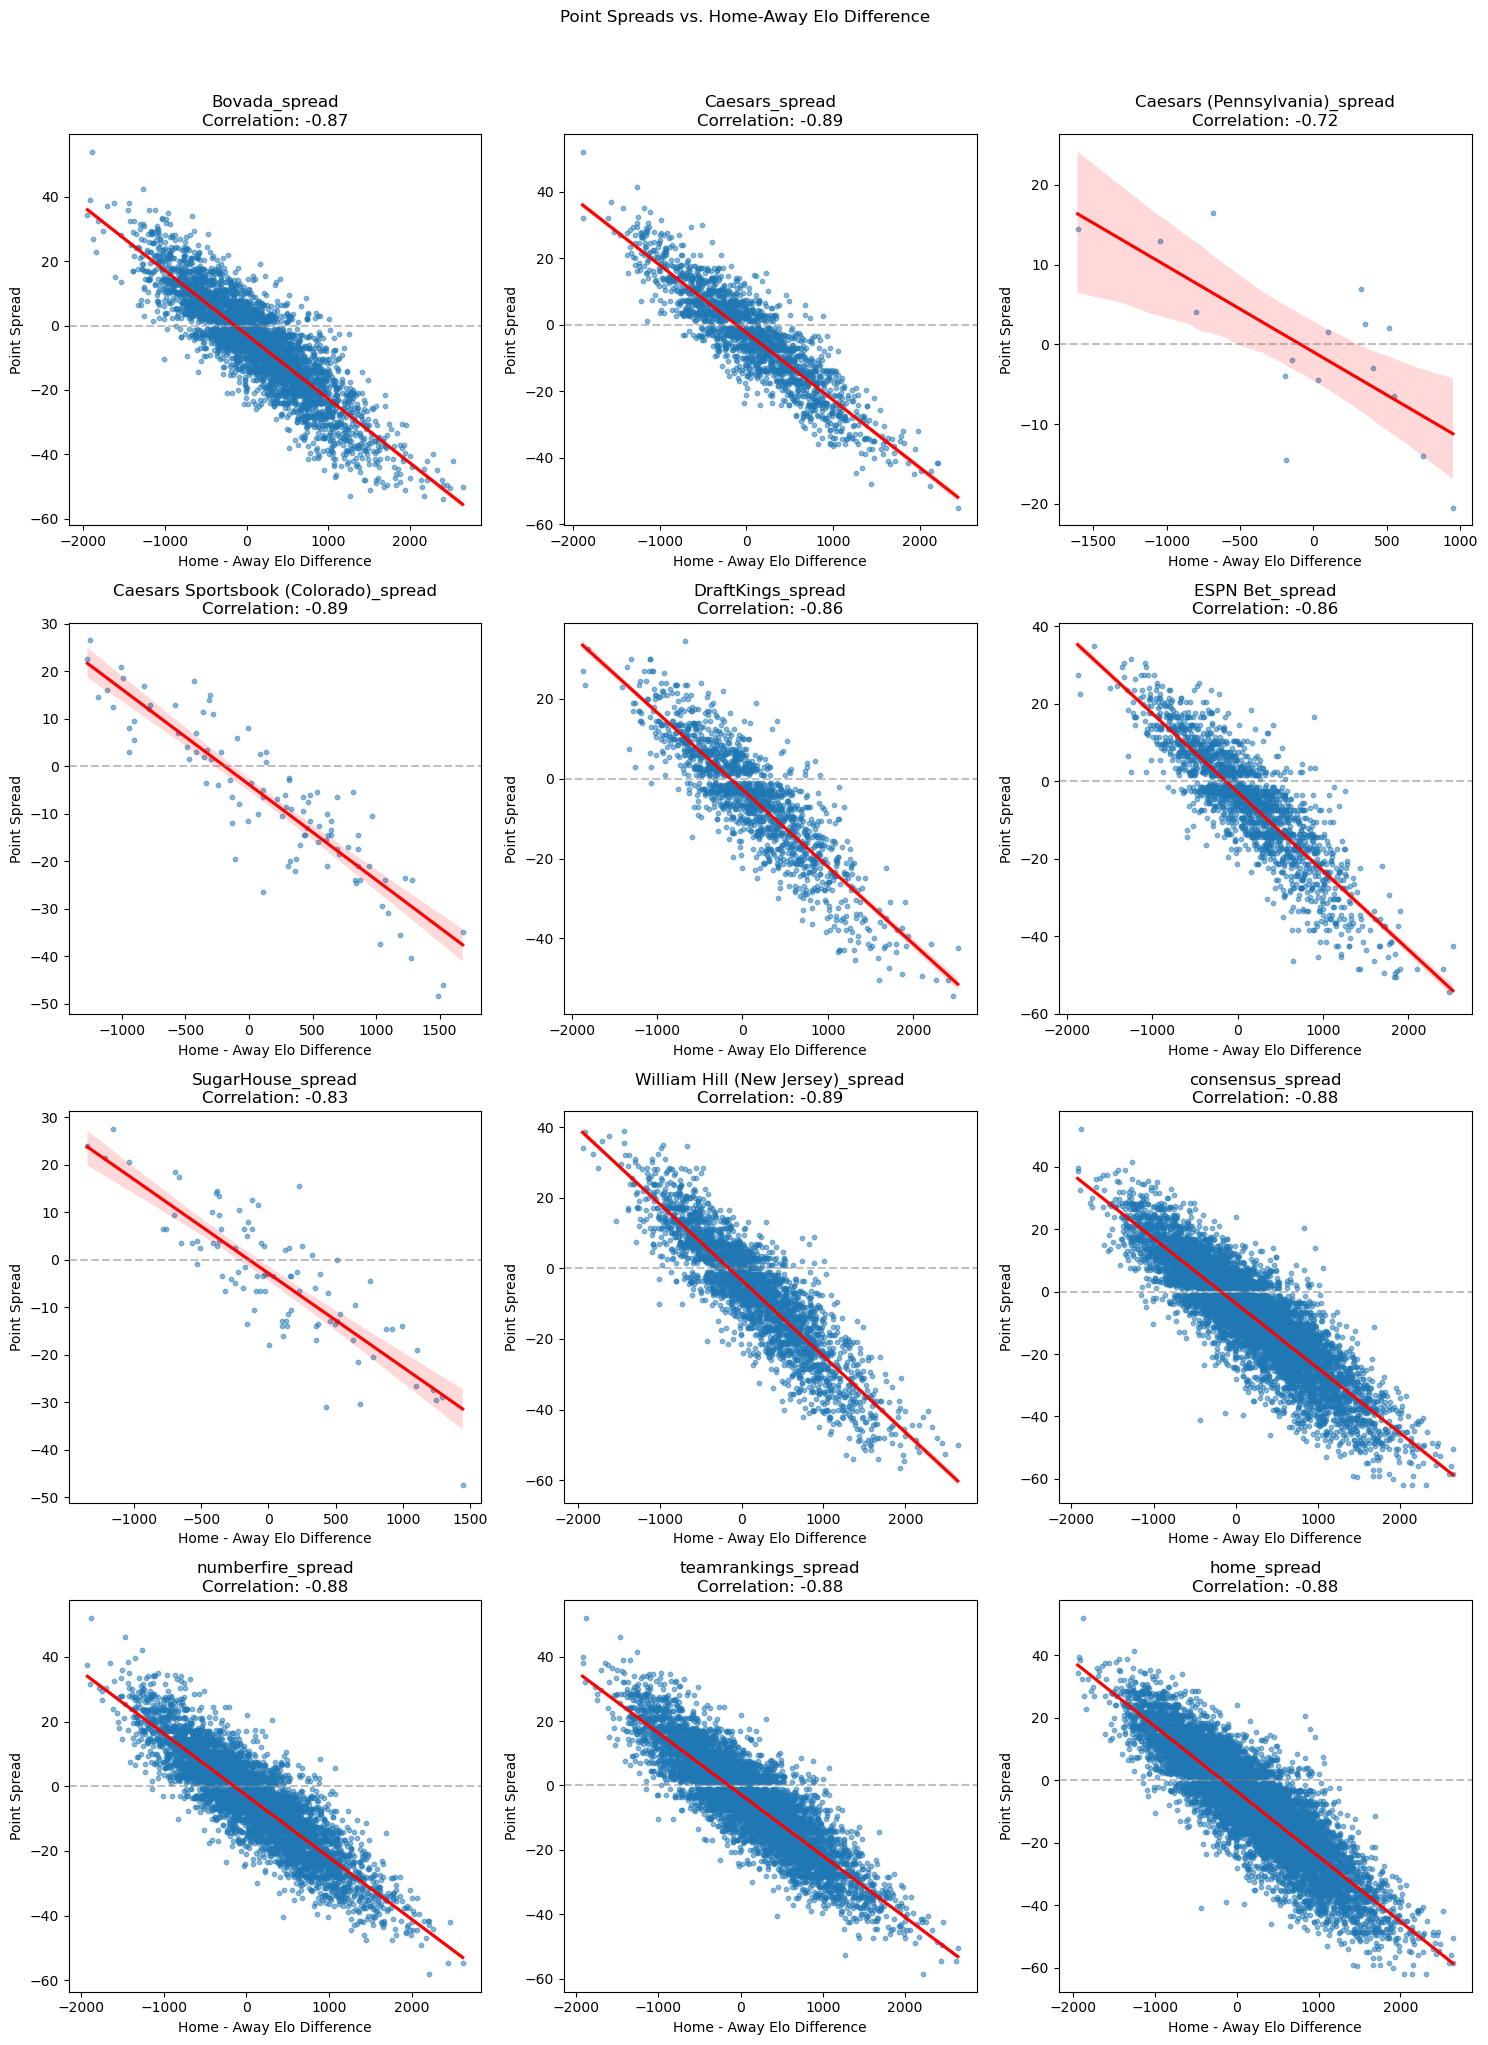

In [10]:
# Verify that all of the point spreads have a negative correlation with the Home - Away Elo difference
# This is a chec to ensure that they are home team point spreads

unique = df.drop_duplicates(subset=['game_id'])

unique['elo_diff'] = unique['home_pregame_elo'] - unique['away_pregame_elo']

spread_cols = ['Bovada_spread', 'Caesars_spread', 'Caesars (Pennsylvania)_spread',
               'Caesars Sportsbook (Colorado)_spread', 'DraftKings_spread', 
               'ESPN Bet_spread', 'SugarHouse_spread',
               'William Hill (New Jersey)_spread', 'consensus_spread',
               'numberfire_spread', 'teamrankings_spread', 'home_spread']

plt.figure(figsize=(15, 20))
plt.suptitle('Point Spreads vs. Home-Away Elo Difference', y=1.02)

for i, col in enumerate(spread_cols, 1):
    ax = plt.subplot(4, 3, i)  # 4 rows, 3 columns of subplots
    
    plot_data = unique.dropna(subset=[col, 'elo_diff'])
    
    sns.regplot(x='elo_diff', y=col, data=plot_data, 
                scatter_kws={'alpha': 0.5, 's': 10},
                line_kws={'color': 'red'})
    
    corr = plot_data['elo_diff'].corr(plot_data[col])
    
    ax.set_title(f'{col}\nCorrelation: {corr:.2f}')
    ax.set_xlabel('Home - Away Elo Difference')
    ax.set_ylabel('Point Spread')
    
    ax.axhline(0, color='gray', linestyle='--', alpha=0.5)

plt.tight_layout()
plt.show()

In [11]:
# drop all spread columns except for the home_spread
spread_cols = ['Bovada_spread', 'Caesars_spread', 'Caesars (Pennsylvania)_spread',
               'Caesars Sportsbook (Colorado)_spread', 'DraftKings_spread', 
               'ESPN Bet_spread', 'SugarHouse_spread',
               'William Hill (New Jersey)_spread', 'consensus_spread',
               'numberfire_spread', 'teamrankings_spread']

df = df.drop(columns=spread_cols)

In [29]:
# Filtering
drop_plays = [
    'End of Regulation',
    'End of Game'
]
df = (
    df
    .query('completed == True') # only completed games
    .query('offense_score >= 0 and defense_score >= 0') # no negative scores
    .query('0 <= clock_minutes <= 15 and 0 <= clock_seconds <= 59') # valid clock
    .query('1 <= period <= 4') # valid period, no and overtime
    .query('0 <= yards_to_goal <= 100') # valid yards to goal
    .query('0 <= distance <= 40') # valid distance within reasonable range
    .query('distance <= yards_to_goal') # distance should be less than yards to goal
    .query('~play_text.isin(@drop_plays)') # drop plays with no play text')
    .assign(
        defense_timeouts = lambda x: np.minimum(np.maximum(x.defense_timeouts, 0), 3),
        offense_timeouts = lambda x: np.minimum(np.maximum(x.offense_timeouts, 0), 3),
    )
    .query('(down == 1 and distance == 10) or down==4') # for a 4th down model, only 1st and 10 or 4th downs
    .reset_index(drop=True)
)

#### Impute the missing home_spread values with a linear regression prediction

In [30]:
from sklearn.linear_model import LinearRegression
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_absolute_error

cols = ['game_id', 'home_spread', 'home_pregame_elo', 'away_pregame_elo']
df_spred_pred = df[cols].query('home_spread.notnull() and home_pregame_elo.notnull() and away_pregame_elo.notnull()').drop_duplicates('game_id')

X = df_spred_pred[['home_pregame_elo', 'away_pregame_elo']]
y = df_spred_pred['home_spread']
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

model = LinearRegression()
model.fit(X_train, y_train)
y_pred = model.predict(X_test)
print(f'MAE: {mean_absolute_error(y_test, y_pred)}')

df['home_spread_pred'] = model.predict(df[['home_pregame_elo', 'away_pregame_elo']])

df['home_spread'] = df['home_spread'].fillna(df['home_spread_pred'])
df.drop(columns=['home_spread_pred'], inplace=True)

MAE: 5.832050552939044


## 3. Feature Engineering

In [31]:
df = (
    df
    .assign(
        seconds_left_in_half = lambda x: np.where(
            x['period'].isin([1,2]), 
            (2 - x['period']) * 15 * 60 + (x['clock_minutes'] * 60 + x['clock_seconds']),
            (4 - x['period']) * 15 * 60 + (x['clock_minutes'] * 60 + x['clock_seconds']),
        ),
        pct_game_played=lambda x: (((x['period'] - 1) * 15 * 60) + (15* 60) - 
                (x['clock_minutes'] * 60 + x['clock_seconds'])
            ) / (15 * 60 * 4),
        game_seconds_remaining = ((4 * 15 * 60) - ((df['period'] - 1) * 15 * 60 + (15 * 60) - (df['clock_minutes'] * 60 + df['clock_seconds']))),
        score_diff = df['offense_score'] - df['defense_score'],
        is_home_team = np.select([df.neutral_site, df.offense == df.home], [0, 1], default=-1),
        pregame_spread = np.where(df['offense'] == df['home'], df['home_spread'], -df['home_spread']),
        pregame_elo_diff = np.where(df['offense'] == df['home'], df['home_pregame_elo'] - df['away_pregame_elo'], df['away_pregame_elo'] - df['home_pregame_elo']),
        pregame_offense_elo = np.where(df['offense'] == df['home'], df['home_pregame_elo'], df['away_pregame_elo']),
        pregame_defense_elo = np.where(df['offense'] == df['home'], df['away_pregame_elo'], df['home_pregame_elo']),
        offense_division = np.where(df['offense'] == df['home'], df['home_division'], df['away_division']),
        defense_division = np.where(df['offense'] == df['home'], df['away_division'], df['home_division']),
        score_diff_final = np.where(df['offense'] == df['home'], df['home_points'] - df['away_points'], df['away_points'] - df['home_points'])
    )

    .assign(
        adjusted_score_diff = lambda x: x['score_diff'] / np.sqrt(1 + x['game_seconds_remaining']),
        diff_time_ratio = lambda x: x['score_diff'] * np.exp(4 * (3600 - x['game_seconds_remaining']) / 3600),
        spread_time_ratio = lambda x: x['pregame_spread'] * np.exp(-4 * (3600 - x['game_seconds_remaining']) / 3600),
        log_pct_game_played = lambda x: np.log(1 - x['pct_game_played'] + 1e-6),
    )
)

df.head()

,game_id,drive_id,play_id,drive_number,play_number,season,week,season_game,week_game,season_type_game,completed,neutral_site,venue_id,home_team,home_id,home_points,away_team,away_id,away_points,season_type,offense,offense_conference,offense_score,defense,home,away,defense_conference,defense_score,period,offense_timeouts,defense_timeouts,yardline,yards_to_goal,down,distance,yards_gained,scoring,play_type,play_text,ppa,clock_minutes,clock_seconds,home_division,home_pregame_elo,away_division,away_pregame_elo,home_spread,seconds_left_in_half,pct_game_played,game_seconds_remaining,score_diff,is_home_team,pregame_spread,pregame_elo_diff,pregame_offense_elo,pregame_defense_elo,offense_division,defense_division,score_diff_final,adjusted_score_diff,diff_time_ratio,spread_time_ratio,log_pct_game_played
0,332412309,33241230916,332412309140,16,15,2013,1,2013,1,regular,True,False,3696.0,Kent State,2309,17.0,Liberty,2335,10.0,regular,Kent State,Mid-American,10,Liberty,Kent State,Liberty,Big South,10,4,1.0,2.0,78,22,4,2,0,False,Timeout,"Timeout Kent State, clock 11:02.",NaN,11,2,fbs,1952.975932,fcs,1551.990878,2.0,662,0.816111,662,0,1,2.0,400.985054,1952.975932,1551.990878,fbs,fcs,7.0,0.0,0.0,0.076436,-1.693418
1,332412309,33241230916,332412309141,16,16,2013,1,2013,1,regular,True,False,3696.0,Kent State,2309,17.0,Liberty,2335,10.0,regular,Kent State,Mid-American,10,Liberty,Kent State,Liberty,Big South,10,4,1.0,2.0,78,22,4,2,39,True,Field Goal Good,Anthony Melchiori 39 yard field goal GOOD.,-0.437012,10,57,fbs,1952.975932,fcs,1551.990878,2.0,657,0.817500,657,0,1,2.0,400.985054,1952.975932,1551.990878,fbs,fcs,7.0,0.0,0.0,0.076013,-1.701000
2,332412309,33241230918,332412309156,18,7,2013,1,2013,1,regular,True,False,3696.0,Kent State,2309,17.0,Liberty,2335,10.0,regular,Kent State,Mid-American,10,Liberty,Kent State,Liberty,Big South,10,4,1.0,2.0,34,66,1,10,8,False,Pass Completion,Colin Reardon pass complete to Anthony Meray f...,1.034050,8,1,fbs,1952.975932,fcs,1551.990878,2.0,481,0.866389,481,0,1,2.0,400.985054,1952.975932,1551.990878,fbs,fcs,7.0,0.0,0.0,0.062511,-2.012814
3,332412309,33241230918,332412309149,18,1,2013,1,2013,1,regular,True,False,3696.0,Kent State,2309,17.0,Liberty,2335,10.0,regular,Kent State,Mid-American,10,Liberty,Kent State,Liberty,Big South,10,4,1.0,2.0,12,88,1,10,3,False,Rush,Colin Reardon rush for 3 yards to the KntSt 15...,-0.160430,8,1,fbs,1952.975932,fcs,1551.990878,2.0,481,0.866389,481,0,1,2.0,400.985054,1952.975932,1551.990878,fbs,fcs,7.0,0.0,0.0,0.062511,-2.012814
4,332412309,33241230918,332412309152,18,3,2013,1,2013,1,regular,True,False,3696.0,Kent State,2309,17.0,Liberty,2335,10.0,regular,Kent State,Mid-American,10,Liberty,Kent State,Liberty,Big South,10,4,1.0,2.0,23,77,1,10,2,False,Rush,Trayion Durham rush for 2 yards to the KntSt 2...,-0.415223,8,1,fbs,1952.975932,fcs,1551.990878,2.0,481,0.866389,481,0,1,2.0,400.985054,1952.975932,1551.990878,fbs,fcs,7.0,0.0,0.0,0.062511,-2.012814


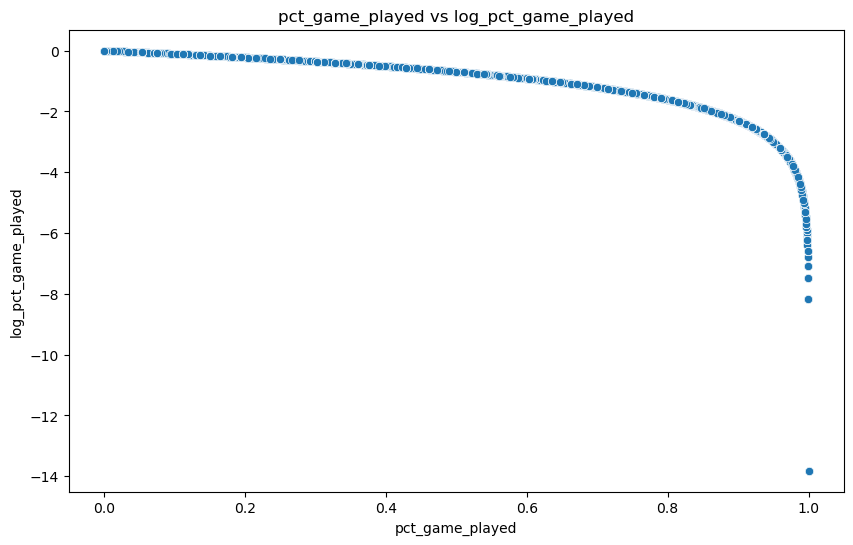

In [17]:
x,y = 'pct_game_played', 'log_pct_game_played'
plt.figure(figsize=(10, 6))
sns.scatterplot(data=df.head(100000), x=x, y=y)
plt.title(f'{x} vs {y}')
plt.xlabel(x)
plt.ylabel(y)
plt.show()

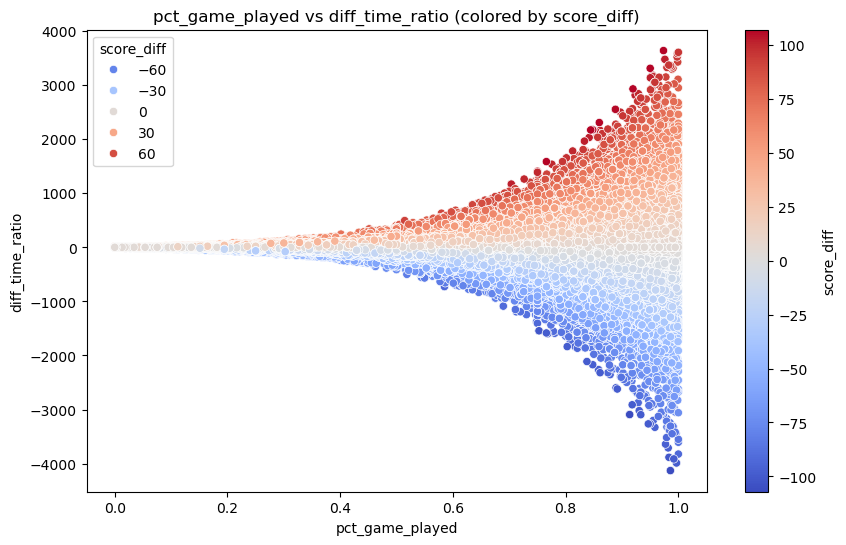

In [18]:
x, y = 'pct_game_played', 'diff_time_ratio'
hue = 'score_diff'

fig, ax = plt.subplots(figsize=(10, 6))  # use subplots to get an Axes object

scatter = sns.scatterplot(data=df.head(100000), x=x, y=y, hue=hue, palette='coolwarm', ax=ax)

# Normalize and create ScalarMappable
norm = mpl.colors.Normalize(vmin=df[hue].min(), vmax=df[hue].max())
sm = mpl.cm.ScalarMappable(cmap='coolwarm', norm=norm)
sm.set_array([])

# Add colorbar to the same Axes
cbar = fig.colorbar(sm, ax=ax)
cbar.set_label(hue)

# Labels
ax.set_title(f'{x} vs {y} (colored by {hue})')
ax.set_xlabel(x)
ax.set_ylabel(y)

plt.show()

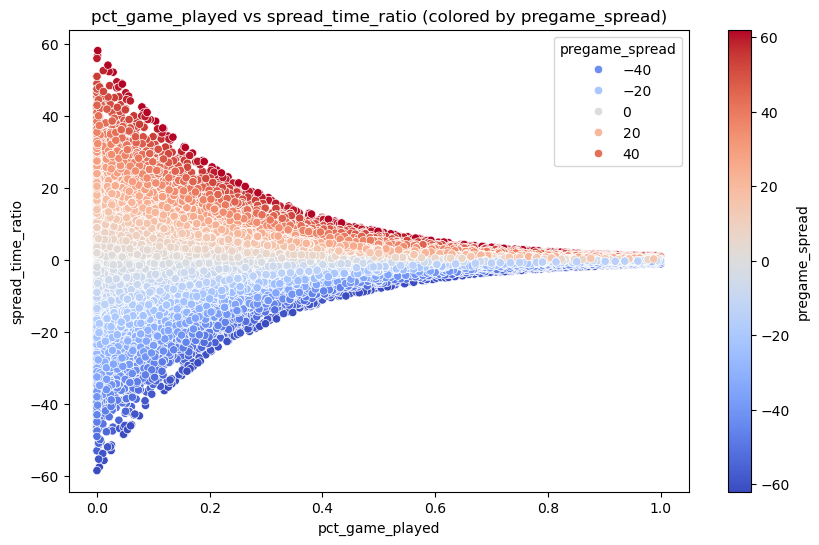

In [19]:
x, y = 'pct_game_played', 'spread_time_ratio'
hue = 'pregame_spread'

fig, ax = plt.subplots(figsize=(10, 6))  # use subplots to get an Axes object

scatter = sns.scatterplot(data=df.head(100000), x=x, y=y, hue=hue, palette='coolwarm', ax=ax)

# Normalize and create ScalarMappable
norm = mpl.colors.Normalize(vmin=df[hue].min(), vmax=df[hue].max())
sm = mpl.cm.ScalarMappable(cmap='coolwarm', norm=norm)
sm.set_array([])

# Add colorbar to the same Axes
cbar = fig.colorbar(sm, ax=ax)
cbar.set_label(hue)

# Labels
ax.set_title(f'{x} vs {y} (colored by {hue})')
ax.set_xlabel(x)
ax.set_ylabel(y)

plt.show()

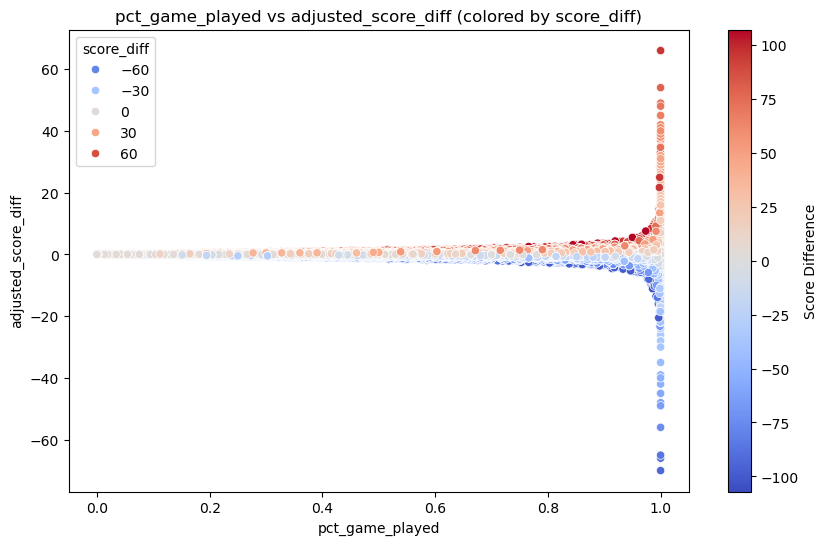

In [20]:
x, y = 'pct_game_played', 'adjusted_score_diff'
fig, ax = plt.subplots(figsize=(10, 6))  # use subplots to get an Axes object

scatter = sns.scatterplot(data=df.head(100000), x=x, y=y, hue='score_diff', palette='coolwarm', ax=ax)

# Normalize and create ScalarMappable
norm = mpl.colors.Normalize(vmin=df['score_diff'].min(), vmax=df['score_diff'].max())
sm = mpl.cm.ScalarMappable(cmap='coolwarm', norm=norm)
sm.set_array([])

# Add colorbar to the same Axes
cbar = fig.colorbar(sm, ax=ax)
cbar.set_label('Score Difference')

# Labels
ax.set_title(f'{x} vs {y} (colored by score_diff)')
ax.set_xlabel(x)
ax.set_ylabel(y)

plt.show()

In [32]:
def seconds_after_kneelout(row, play_clock=40, kneel_duration=2):
    """
    Returns the number of seconds remaining after the offense kneels out the game,
    simulating play-by-play, including two-minute warning and downs.
    """
    seconds = row['game_seconds_remaining']
    timeouts = row['defense_timeouts']
    downs_remaining = 4 - row['down']
    prior_to_two_minute = seconds > 120
        
    while seconds > 0 and downs_remaining > 0:
        # Add kneel duration first
        seconds -= kneel_duration
        
        if prior_to_two_minute and seconds <= 120:
            prior_to_two_minute = False
        elif timeouts > 0:
            timeouts -= 1
        else:
            if prior_to_two_minute and seconds <= (120 + play_clock):
                prior_to_two_minute = False
                seconds = 120
            else:
                # Burn full play clock
                seconds -= play_clock
        downs_remaining -= 1
    
    return max(seconds, 0)

from tqdm import tqdm
tqdm.pandas()

df['seconds_after_kneelout'] = df.progress_apply(seconds_after_kneelout, axis=1)

100%|██████████| 969145/969145 [00:05<00:00, 170669.97it/s]


In [33]:
# df['can_kneel_out'] = np.where(
#     df.seconds_after_kneelout == 0,
#     4,
#     np.where(
#         df.seconds_after_kneelout <= 30,
#         3,
#         np.where(
#             df.seconds_after_kneelout <= 60,
#             2,
#             np.where(
#                 df.seconds_after_kneelout <= 90,
#                 1,
#                 0
#             )
#         )
#     )
# )
df['can_kneel_out'] = df.seconds_after_kneelout <= 0
df['can_kneel_out_30'] = df.seconds_after_kneelout <= 30
df['can_kneel_out_60'] = df.seconds_after_kneelout <= 60
df['can_kneel_out_90'] = df.seconds_after_kneelout <= 90

## 4. Final Data

In [34]:
df.shape

(969145, 68)

In [35]:
df.head()

,game_id,drive_id,play_id,drive_number,play_number,season,week,season_game,week_game,season_type_game,completed,neutral_site,venue_id,home_team,home_id,home_points,away_team,away_id,away_points,season_type,offense,offense_conference,offense_score,defense,home,away,defense_conference,defense_score,period,offense_timeouts,defense_timeouts,yardline,yards_to_goal,down,distance,yards_gained,scoring,play_type,play_text,ppa,clock_minutes,clock_seconds,home_division,home_pregame_elo,away_division,away_pregame_elo,home_spread,seconds_left_in_half,pct_game_played,game_seconds_remaining,score_diff,is_home_team,pregame_spread,pregame_elo_diff,pregame_offense_elo,pregame_defense_elo,offense_division,defense_division,score_diff_final,adjusted_score_diff,diff_time_ratio,spread_time_ratio,log_pct_game_played,seconds_after_kneelout,can_kneel_out,can_kneel_out_30,can_kneel_out_60,can_kneel_out_90
0,332412309,33241230916,332412309140,16,15,2013,1,2013,1,regular,True,False,3696.0,Kent State,2309,17.0,Liberty,2335,10.0,regular,Kent State,Mid-American,10,Liberty,Kent State,Liberty,Big South,10,4,1.0,2.0,78,22,4,2,0,False,Timeout,"Timeout Kent State, clock 11:02.",NaN,11,2,fbs,1952.975932,fcs,1551.990878,2.0,662,0.816111,662,0,1,2.0,400.985054,1952.975932,1551.990878,fbs,fcs,7.0,0.0,0.0,0.076436,-1.693418,662,False,False,False,False
1,332412309,33241230916,332412309141,16,16,2013,1,2013,1,regular,True,False,3696.0,Kent State,2309,17.0,Liberty,2335,10.0,regular,Kent State,Mid-American,10,Liberty,Kent State,Liberty,Big South,10,4,1.0,2.0,78,22,4,2,39,True,Field Goal Good,Anthony Melchiori 39 yard field goal GOOD.,-0.437012,10,57,fbs,1952.975932,fcs,1551.990878,2.0,657,0.817500,657,0,1,2.0,400.985054,1952.975932,1551.990878,fbs,fcs,7.0,0.0,0.0,0.076013,-1.701000,657,False,False,False,False
2,332412309,33241230918,332412309156,18,7,2013,1,2013,1,regular,True,False,3696.0,Kent State,2309,17.0,Liberty,2335,10.0,regular,Kent State,Mid-American,10,Liberty,Kent State,Liberty,Big South,10,4,1.0,2.0,34,66,1,10,8,False,Pass Completion,Colin Reardon pass complete to Anthony Meray f...,1.034050,8,1,fbs,1952.975932,fcs,1551.990878,2.0,481,0.866389,481,0,1,2.0,400.985054,1952.975932,1551.990878,fbs,fcs,7.0,0.0,0.0,0.062511,-2.012814,435,False,False,False,False
3,332412309,33241230918,332412309149,18,1,2013,1,2013,1,regular,True,False,3696.0,Kent State,2309,17.0,Liberty,2335,10.0,regular,Kent State,Mid-American,10,Liberty,Kent State,Liberty,Big South,10,4,1.0,2.0,12,88,1,10,3,False,Rush,Colin Reardon rush for 3 yards to the KntSt 15...,-0.160430,8,1,fbs,1952.975932,fcs,1551.990878,2.0,481,0.866389,481,0,1,2.0,400.985054,1952.975932,1551.990878,fbs,fcs,7.0,0.0,0.0,0.062511,-2.012814,435,False,False,False,False
4,332412309,33241230918,332412309152,18,3,2013,1,2013,1,regular,True,False,3696.0,Kent State,2309,17.0,Liberty,2335,10.0,regular,Kent State,Mid-American,10,Liberty,Kent State,Liberty,Big South,10,4,1.0,2.0,23,77,1,10,2,False,Rush,Trayion Durham rush for 2 yards to the KntSt 2...,-0.415223,8,1,fbs,1952.975932,fcs,1551.990878,2.0,481,0.866389,481,0,1,2.0,400.985054,1952.975932,1551.990878,fbs,fcs,7.0,0.0,0.0,0.062511,-2.012814,435,False,False,False,False


In [38]:
cols = ['game_id', 'drive_id', 'play_id', 'season', 'week', 'season_type', 'venue_id', 
        'offense', 'offense_conference', 'offense_division', 
        'defense', 'defense_conference', 'defense_division', 
        'score_diff', 'pregame_elo_diff', 'pregame_offense_elo', 'pregame_defense_elo', 'pct_game_played',
        'seconds_left_in_half',
        'offense_timeouts', 'defense_timeouts', 'is_home_team', 'yards_to_goal', 'down', 'distance', 
        'seconds_after_kneelout',
        'can_kneel_out', 'can_kneel_out_30', 'can_kneel_out_60', 'can_kneel_out_90',
        'pregame_spread', 'adjusted_score_diff', 'diff_time_ratio',
        'spread_time_ratio', 'log_pct_game_played',
        'score_diff_final']

# Only FBS offense
data = df[cols].query('offense_division == "fbs"').reset_index(drop=True)
print(f'After filtering to FBS offense, {data.shape[0]} plays remain.')
data['downxdistance'] = data['down'] * data['distance']
data['won'] = np.where(data['score_diff_final'] > 0, 1, 0)
data.head()

After filtering to FBS offense, 783514 plays remain.


,game_id,drive_id,play_id,season,week,season_type,venue_id,offense,offense_conference,offense_division,defense,defense_conference,defense_division,score_diff,pregame_elo_diff,pregame_offense_elo,pregame_defense_elo,pct_game_played,seconds_left_in_half,offense_timeouts,defense_timeouts,is_home_team,yards_to_goal,down,distance,seconds_after_kneelout,can_kneel_out,can_kneel_out_30,can_kneel_out_60,can_kneel_out_90,pregame_spread,adjusted_score_diff,diff_time_ratio,spread_time_ratio,log_pct_game_played,score_diff_final,downxdistance,won
0,332412309,33241230916,332412309140,2013,1,regular,3696.0,Kent State,Mid-American,fbs,Liberty,Big South,fcs,0,400.985054,1952.975932,1551.990878,0.816111,662,1.0,2.0,1,22,4,2,662,False,False,False,False,2.0,0.0,0.0,0.076436,-1.693418,7.0,8,1
1,332412309,33241230916,332412309141,2013,1,regular,3696.0,Kent State,Mid-American,fbs,Liberty,Big South,fcs,0,400.985054,1952.975932,1551.990878,0.817500,657,1.0,2.0,1,22,4,2,657,False,False,False,False,2.0,0.0,0.0,0.076013,-1.701000,7.0,8,1
2,332412309,33241230918,332412309156,2013,1,regular,3696.0,Kent State,Mid-American,fbs,Liberty,Big South,fcs,0,400.985054,1952.975932,1551.990878,0.866389,481,1.0,2.0,1,66,1,10,435,False,False,False,False,2.0,0.0,0.0,0.062511,-2.012814,7.0,10,1
3,332412309,33241230918,332412309149,2013,1,regular,3696.0,Kent State,Mid-American,fbs,Liberty,Big South,fcs,0,400.985054,1952.975932,1551.990878,0.866389,481,1.0,2.0,1,88,1,10,435,False,False,False,False,2.0,0.0,0.0,0.062511,-2.012814,7.0,10,1
4,332412309,33241230918,332412309152,2013,1,regular,3696.0,Kent State,Mid-American,fbs,Liberty,Big South,fcs,0,400.985054,1952.975932,1551.990878,0.866389,481,1.0,2.0,1,77,1,10,435,False,False,False,False,2.0,0.0,0.0,0.062511,-2.012814,7.0,10,1


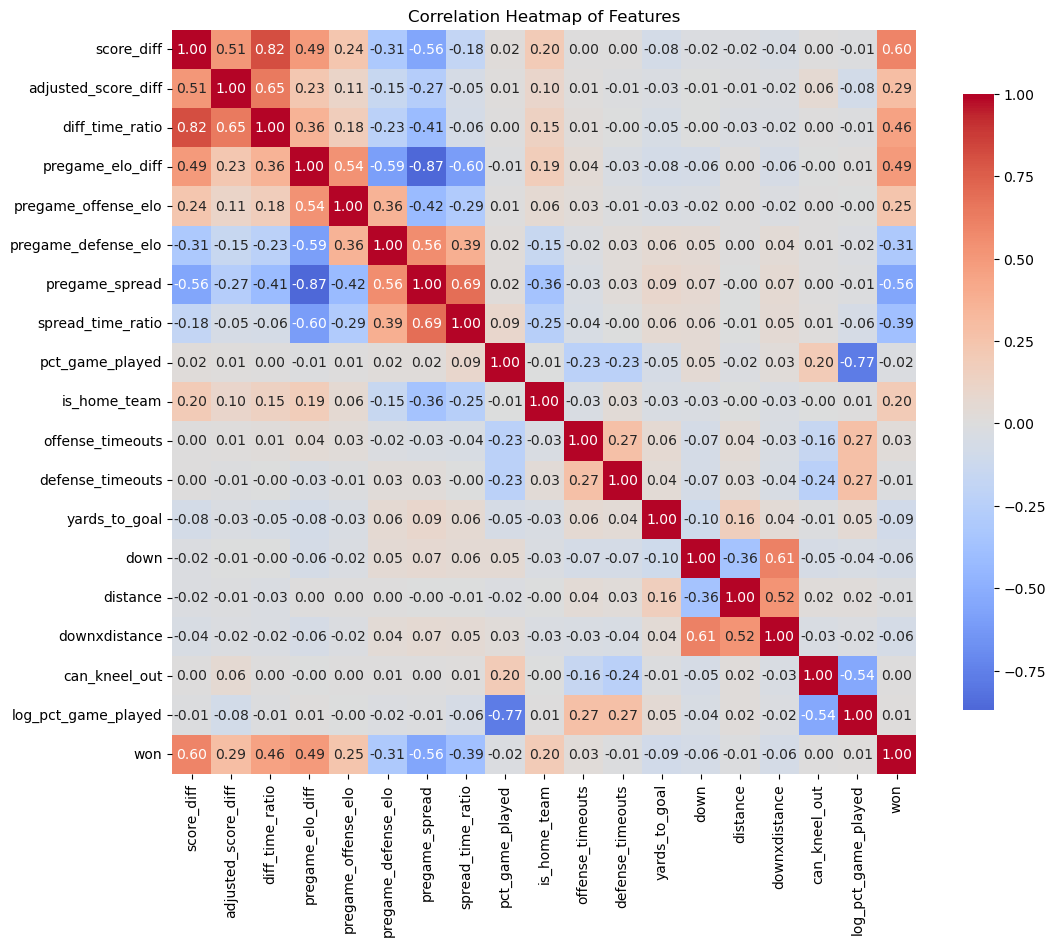

In [39]:
features = [
    'score_diff',
    'adjusted_score_diff',
    'diff_time_ratio',
    'pregame_elo_diff',
    'pregame_offense_elo',
    'pregame_defense_elo',
    'pregame_spread',
    'spread_time_ratio',
    'pct_game_played',
    'is_home_team',
    'offense_timeouts',
    'defense_timeouts',
    'yards_to_goal',
    'down',
    'distance',
    'downxdistance',
    'can_kneel_out',
    'log_pct_game_played',
]

feature_set = features + ['won']

# correlation heatmap
plt.figure(figsize=(12, 10))
sns.heatmap(
    data[feature_set].corr(), 
    annot=True, 
    fmt=".2f", 
    cmap='coolwarm', 
    center=0,
    square=True,
    cbar_kws={"shrink": .8}
)
plt.title('Correlation Heatmap of Features')
plt.show()

In [40]:
import optuna
import xgboost as xgb
from sklearn.model_selection import train_test_split
from sklearn.metrics import log_loss
from tqdm import tqdm

# optuna.logging.set_verbosity(optuna.logging.CRITICAL)
SEED = 2
np.random.seed(SEED)

feature_names = [
    'score_diff',
    'diff_time_ratio',
    'spread_time_ratio',
    'pregame_offense_elo',
    'pregame_defense_elo',
    'pct_game_played',
    'seconds_left_in_half',
    'is_home_team',
    'offense_timeouts',
    'defense_timeouts',
    'yards_to_goal',
    'down',
    'distance',
    'seconds_after_kneelout'
    # 'can_kneel_out',
    # 'can_kneel_out_30',
    # 'can_kneel_out_60',
    # 'can_kneel_out_90',
]

# Split into 80-20 train val set by game_id
game_ids = df.game_id.unique()
game_ids_train, game_ids_test = train_test_split(game_ids, test_size=0.2, random_state=SEED)

data_train = data[data.game_id.isin(game_ids_train)]
data_test = data[data.game_id.isin(game_ids_test)].drop(columns=['drive_id'])
game_ids_train, game_ids_valid = train_test_split(
    data_train.game_id.unique(), 
    test_size=0.2, 
    random_state=SEED
)
train = data_train[data_train.game_id.isin(game_ids_train)]
valid = data_train[data_train.game_id.isin(game_ids_valid)]

# Prepare features and monotonic constraints
monotonic_constraints_map = {
    "score_diff": 1,
    "diff_time_ratio": 1,
    "spread_time_ratio": -1,
    "pregame_offense_elo": 1,
    "pregame_defense_elo": -1,
    "is_home_team": 1,
    "offense_timeouts": 1,
    "defense_timeouts": -1,
    "yards_to_goal": -1,
    "down": -1,
}
monotonic_constraints = tuple([monotonic_constraints_map.get(feature, 0) for feature in feature_names])

# Objective function for Optuna
def objective(trial, dtrain, dvalid):
    param = {
        "nthread": -1,
        "objective": "binary:logistic",
        "monotone_constraints": monotonic_constraints,
        "eval_metric": "logloss",
        "booster": "gbtree",
        "lambda": trial.suggest_float("lambda", 1e-5, 10.0, log=True),
        "alpha": trial.suggest_float("alpha", 1e-5, 10.0, log=True),
        "eta": trial.suggest_float("eta", 0.05, 0.3, step=0.01),
        "max_depth": trial.suggest_int("max_depth", 3, 9, step=2),
        "min_child_weight": trial.suggest_float("min_child_weight", .5, 10, step=.5),
        "gamma": trial.suggest_float("gamma", 1e-8, 5.0, log=True),
        "grow_policy": trial.suggest_categorical("grow_policy", ["depthwise", "lossguide"]),
        "subsample": trial.suggest_float("subsample", 0.5, 1.0),
        "colsample_bytree": trial.suggest_float("colsample_bytree", 0.5, 1.0),
    }
    
    evals_result = {}
    bst = xgb.train(
        param, 
        dtrain,
        num_boost_round=500,
        evals=[(dvalid, "eval")],
        early_stopping_rounds=10,
        evals_result=evals_result,
        verbose_eval=False
    )
    # Report per-round validation loss to Optuna
    for i, loss in enumerate(evals_result["eval"]["logloss"]):
        trial.report(loss, step=i)
        if trial.should_prune():
            raise optuna.TrialPruned()

    preds = bst.predict(dvalid)
    return log_loss(valid_y, preds)

train_x = train[feature_names]
train_y = train['won']
valid_x = valid[feature_names]
valid_y = valid['won']

# Create DMatrix objects
dtrain = xgb.DMatrix(train_x, label=train_y)
dvalid = xgb.DMatrix(valid_x, label=valid_y)

# Run Optuna optimization
study = optuna.create_study(
    study_name="win_probability_hyperopt", 
    direction="minimize", 
    load_if_exists=False,
)
study.optimize(lambda trial: objective(trial, dtrain, dvalid), n_trials=50)

# Train final model with best parameters
best_params = {
    **study.best_trial.params,
    'nthread': -1,
    'objective': 'binary:logistic',
    'booster': 'gbtree',
    'monotone_constraints': monotonic_constraints,
    'eval_metric': 'logloss',
    'seed': SEED,
}

final_model = xgb.train(
    best_params, 
    dtrain,
    num_boost_round=500,
    evals=[(dvalid, "eval")],
    early_stopping_rounds=10,
    verbose_eval=False
)

# Evaluate on train set
train_preds = final_model.predict(dtrain)
print(f"Final train log loss: {log_loss(train_y, train_preds):0.3f}")

# Evaluate on validation set
valid_preds = final_model.predict(dvalid)
print(f"Final validation log loss: {log_loss(valid_y, valid_preds):0.3f}")

# Evaluate on test set
dtest = xgb.DMatrix(data_test[feature_names], label=data_test['won'])
test_preds = final_model.predict(dtest)
print(f"Final test log loss: {log_loss(data_test['won'], test_preds):0.3f}")

[I 2025-09-28 19:03:01,933] A new study created in memory with name: win_probability_hyperopt
[I 2025-09-28 19:03:03,882] Trial 0 finished with value: 0.3572605459802818 and parameters: {'lambda': 0.0036562579028937415, 'alpha': 0.00018737476575338632, 'eta': 0.13, 'max_depth': 3, 'min_child_weight': 2.5, 'gamma': 0.000266450813339088, 'grow_policy': 'lossguide', 'subsample': 0.903696527973157, 'colsample_bytree': 0.6242314999357764}. Best is trial 0 with value: 0.3572605459802818.
[I 2025-09-28 19:03:07,009] Trial 1 finished with value: 0.3551794092468936 and parameters: {'lambda': 4.2853600302438276e-05, 'alpha': 0.5146798621739542, 'eta': 0.08, 'max_depth': 5, 'min_child_weight': 8.5, 'gamma': 0.02992047546308325, 'grow_policy': 'depthwise', 'subsample': 0.985431805001596, 'colsample_bytree': 0.548472879279355}. Best is trial 1 with value: 0.3551794092468936.
[I 2025-09-28 19:03:08,853] Trial 2 finished with value: 0.35661211994520575 and parameters: {'lambda': 1.1996506473301695e-0

Final train log loss: 0.349
Final validation log loss: 0.355
Final test log loss: 0.350


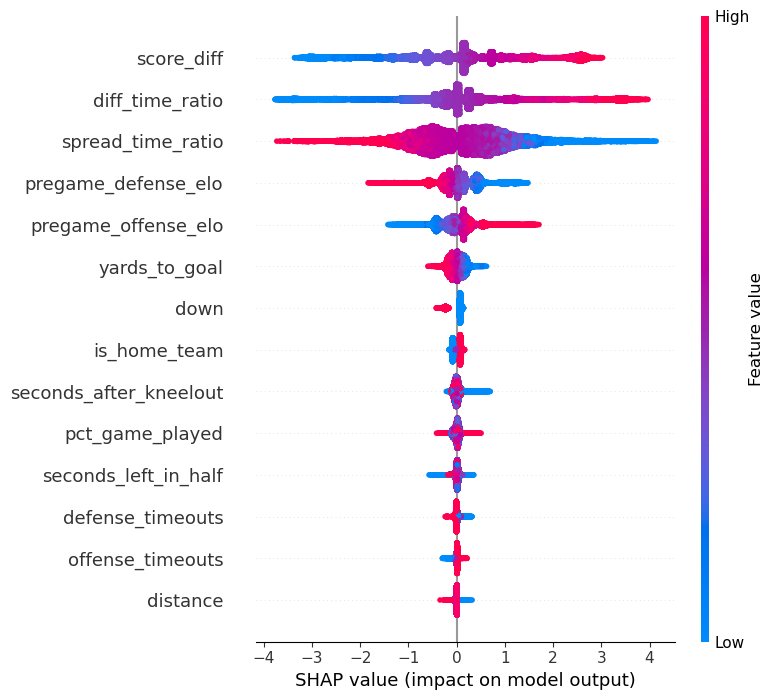

In [41]:
background = train[feature_names].head(50000)
explainer = shap.TreeExplainer(final_model)
shap_values = explainer.shap_values(background)
shap.summary_plot(shap_values, 
                 background, 
                 plot_type="dot",  # "dot" (default), "bar", or "violin"
                 max_display=15,
                 show=True)

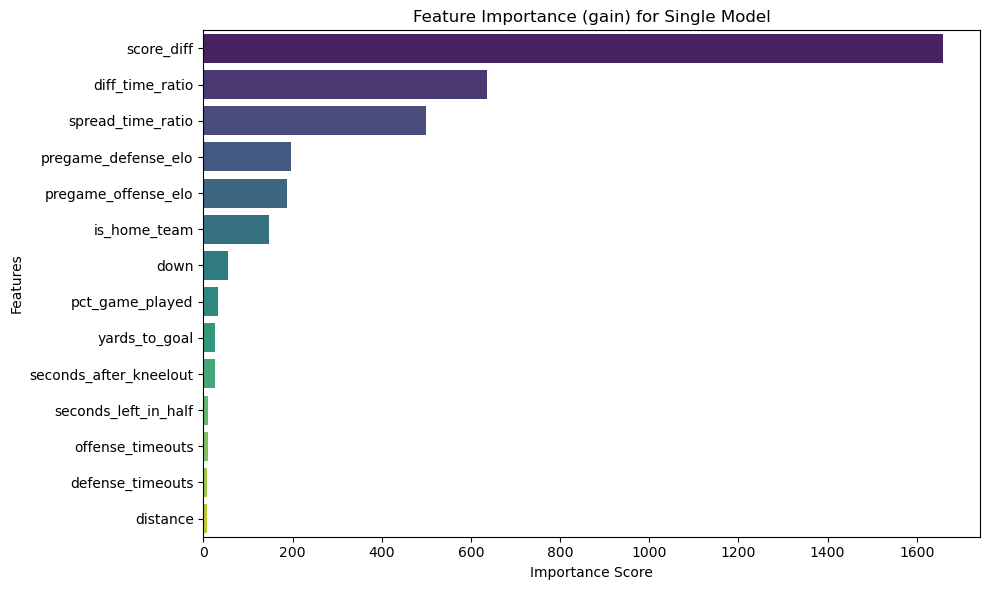

In [42]:
importance_type = "gain"  # Options: "gain", "weight", "cover"

# Get feature importance for a single model
importance = final_model.get_score(importance_type=importance_type)

# Convert to DataFrame and sort
importance_df = pd.DataFrame({
    "Feature": list(importance.keys()),
    "Importance": list(importance.values())
}).sort_values(by="Importance", ascending=False)

# Plot
plt.figure(figsize=(10, 6))
sns.barplot(
    x="Importance", 
    y="Feature", 
    data=importance_df, 
    palette="viridis", 
    hue="Feature", 
    dodge=False
)
plt.title(f"Feature Importance ({importance_type}) for Single Model")
plt.xlabel("Importance Score")
plt.ylabel("Features")
plt.legend([], [], frameon=False)
plt.tight_layout()
plt.show()

0.9970583


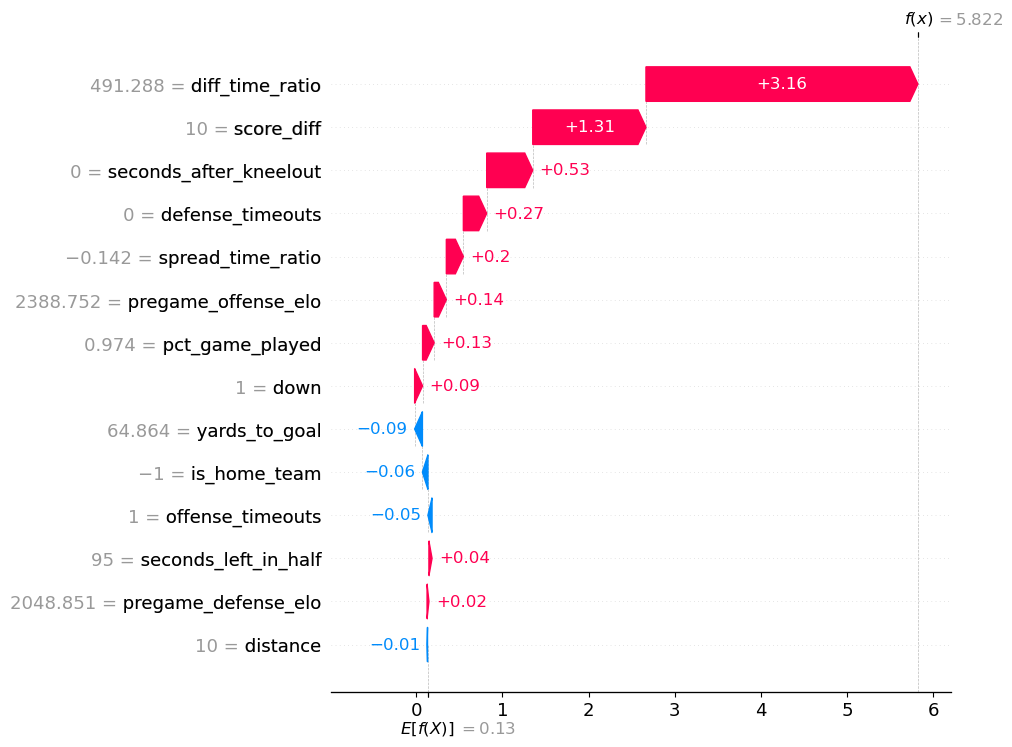

In [43]:
game_state =   {
    "score_diff": 10,
    "diff_time_ratio": 491.28752028555186,
    "spread_time_ratio": -0.14248275624691992,
    "pregame_offense_elo": 2388.75209490804,
    "pregame_defense_elo": 2048.851043935348,
    "pct_game_played": 0.9736111111111111,
    "seconds_left_in_half": 95.0,
    "is_home_team": -1,
    "offense_timeouts": 1,
    "defense_timeouts": 0,
    "yards_to_goal": 64.86350875856735,
    "down": 1,
    "distance": 10,
    "seconds_after_kneelout": 0
  }

print(final_model.predict(xgb.DMatrix(pd.DataFrame([game_state])))[0])

# show waterfall plot for the above prediction
input_df = pd.DataFrame([game_state])[feature_names]  # enforce column order

dmatrix = xgb.DMatrix(input_df, feature_names=feature_names)
shap_exp = explainer(dmatrix)[0]

# Attach feature names explicitly
shap_exp.feature_names = feature_names

# Now plot with the correct labels
shap.plots.waterfall(shap_exp, max_display=15, show=True)

In [27]:
game_state = {
    'score_diff': -14,
    'diff_time_ratio': -7 * np.exp(4 * (3600 - 72) / 3600),
    'spread_time_ratio':  -3 * np.exp(-4 * (3600 - 72) / 3600),
    'pregame_offense_elo': 1500,
    'pregame_defense_elo': 1450,
    'pct_game_played': 0.98,
    'seconds_left_in_half': 72,
    'is_home_team': 1,
    'offense_timeouts': 0,
    'defense_timeouts': 2,
    'yards_to_goal': 90,
    'down': 4,
    'distance': 15,
    'seconds_after_kneelout': 0,
    # 'can_kneel_out': 0,
    # 'can_kneel_out_30': 0,
    # 'can_kneel_out_60': 0,
    # 'can_kneel_out_90': 0,
}

convert_proba = 0.1

convert_game_state = game_state.copy()
convert_game_state['yards_to_goal'] = convert_game_state['yards_to_goal'] - convert_game_state['distance']
convert_game_state['down'] = 1
convert_game_state['distance'] = 10
convert_wp = final_model.predict(xgb.DMatrix(pd.DataFrame([convert_game_state])))[0] * 100

fail_convert_game_state = game_state.copy()
fail_convert_game_state['score_diff'] = fail_convert_game_state['score_diff'] * -1
fail_convert_game_state['diff_time_ratio'] = fail_convert_game_state['diff_time_ratio'] * -1
fail_convert_game_state['spread_time_ratio'] = fail_convert_game_state['spread_time_ratio'] * -1
fail_convert_game_state['pregame_offense_elo'] = 1450
fail_convert_game_state['pregame_defense_elo'] = 1500
offense_timeouts, defense_timeouts = fail_convert_game_state['offense_timeouts'], fail_convert_game_state['defense_timeouts']
fail_convert_game_state['offense_timeouts'] = defense_timeouts
fail_convert_game_state['defense_timeouts'] = offense_timeouts
fail_convert_game_state['is_home_team'] = -1 if fail_convert_game_state['is_home_team'] == 1 else (1 if fail_convert_game_state['is_home_team'] == -1 else 0)
fail_convert_game_state['yards_to_goal'] = 100 - fail_convert_game_state['yards_to_goal']
fail_convert_game_state['down'] = 1
fail_convert_game_state['distance'] = 10
# fail_convert_game_state['can_kneel_out'] = 1
# fail_convert_game_state['can_kneel_out_30'] = 1
# fail_convert_game_state['can_kneel_out_60'] = 1
# fail_convert_game_state['can_kneel_out_90'] = 1
fail_convert_wp = 100 - (final_model.predict(xgb.DMatrix(pd.DataFrame([fail_convert_game_state])))[0] * 100)

punt_game_state = game_state.copy()
punt_game_state['score_diff'] = punt_game_state['score_diff'] * -1
punt_game_state['diff_time_ratio'] = punt_game_state['diff_time_ratio'] * -1
punt_game_state['spread_time_ratio'] = punt_game_state['spread_time_ratio'] * -1
punt_game_state['pregame_offense_elo'] = 1450
punt_game_state['pregame_defense_elo'] = 1500
offense_timeouts, defense_timeouts = punt_game_state['offense_timeouts'], punt_game_state['defense_timeouts']
punt_game_state['offense_timeouts'] = defense_timeouts
punt_game_state['defense_timeouts'] = offense_timeouts
punt_game_state['is_home_team'] = -1 if punt_game_state['is_home_team'] == 1 else (1 if punt_game_state['is_home_team'] == -1 else 0)
punt_game_state['yards_to_goal'] = 80
punt_game_state['down'] = 1
punt_game_state['distance'] = 10
# punt_game_state['can_kneel_out'] = 1
# punt_game_state['can_kneel_out_30'] = 1
# punt_game_state['can_kneel_out_60'] = 1
# punt_game_state['can_kneel_out_90'] = 1
punt_wp = 100 - (final_model.predict(xgb.DMatrix(pd.DataFrame([punt_game_state])))[0] * 100)

exp_wp_go = (convert_proba * convert_wp) + ((1 - convert_proba) * fail_convert_wp)
exp_wp_punt = punt_wp
print(f"Win Probability if go for it: {exp_wp_go:0.2f}%")
print(f"Win Probability if punt: {exp_wp_punt:0.2f}%")

Win Probability if go for it: 0.50%
Win Probability if punt: 0.84%


In [27]:
punt_wp

0.7346868515014648

In [28]:
convert_wp

2.783207781612873

In [29]:
fail_convert_wp

0.2930939197540283

In [44]:
# predict win_proba for all plays
df['win_proba'] = final_model.predict(xgb.DMatrix(df[feature_names]))

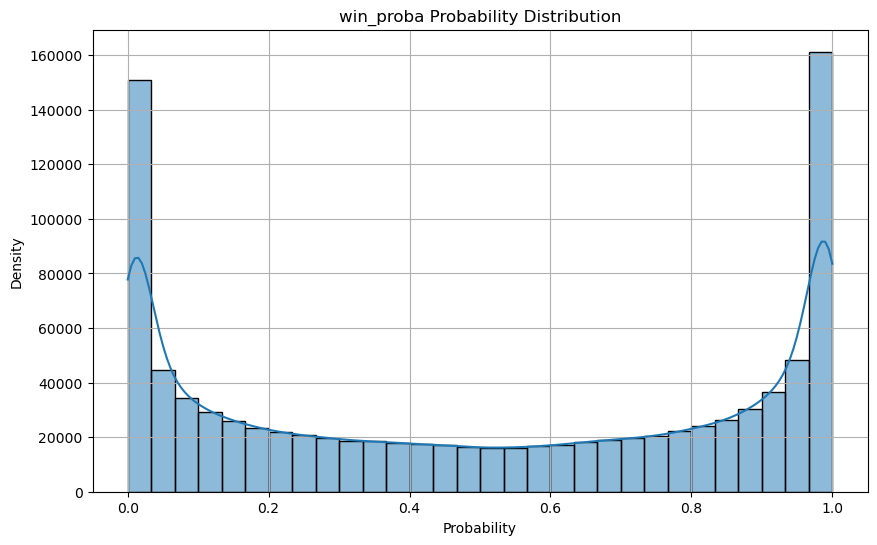

In [45]:
# plot win probability
def plot_wp(df, col):
    plt.figure(figsize=(10, 6))
    sns.histplot(df[col], bins=30, kde=True)
    plt.title(f'{col} Probability Distribution')
    plt.xlabel('Probability')
    plt.ylabel('Density')
    plt.grid()
    plt.show()
plot_wp(df, col='win_proba')

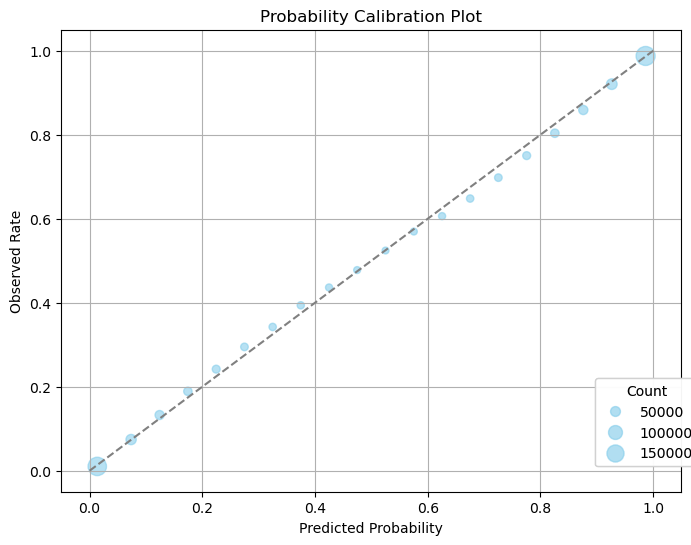

In [46]:
calibration = pd.DataFrame()
def plot_calibration(df, proba_col, actual_col, bins=100, scale=0.2):
    global calibration
    df['proba_bin'] = pd.cut(df[proba_col], bins=np.linspace(0, 1, bins + 1), labels=False, include_lowest=True)
    calibration = df.groupby('proba_bin').agg(
        predicted_proba=(proba_col, 'mean'),
        actual_proba=(actual_col, 'mean'),
        count=(proba_col, 'size')
    ).reset_index()

    plt.figure(figsize=(8, 6))
    scatter = plt.scatter(
        calibration['predicted_proba'], 
        calibration['actual_proba'], 
        s=calibration['count'] * scale,
        alpha=0.6, 
        label='Calibration Curve',
        color='skyblue',
    )
    plt.plot([0, 1], [0, 1], linestyle='--', color='gray', label='Perfect Calibration')
    plt.xlabel('Predicted Probability')
    plt.ylabel('Observed Rate')
    plt.title('Probability Calibration Plot')
    plt.grid()

    # Add legend for dot size reference
    handles, labels = scatter.legend_elements(prop="sizes", alpha=0.6, num=4, func=lambda x: x / scale,
                                              color='skyblue')
    labels = [int(re.search(r'\{(\d+)\}', value).group(1)) for value in labels]
    legend = plt.legend(handles, labels, title="Count", loc="center left", bbox_to_anchor=(.85, 0.15))
    plt.gca().add_artist(legend)

    plt.show()

df['won'] = np.where(df['score_diff_final'] > 0, 1, 0)
plot_calibration(df, proba_col='win_proba', actual_col='won', bins=20, scale=0.001)

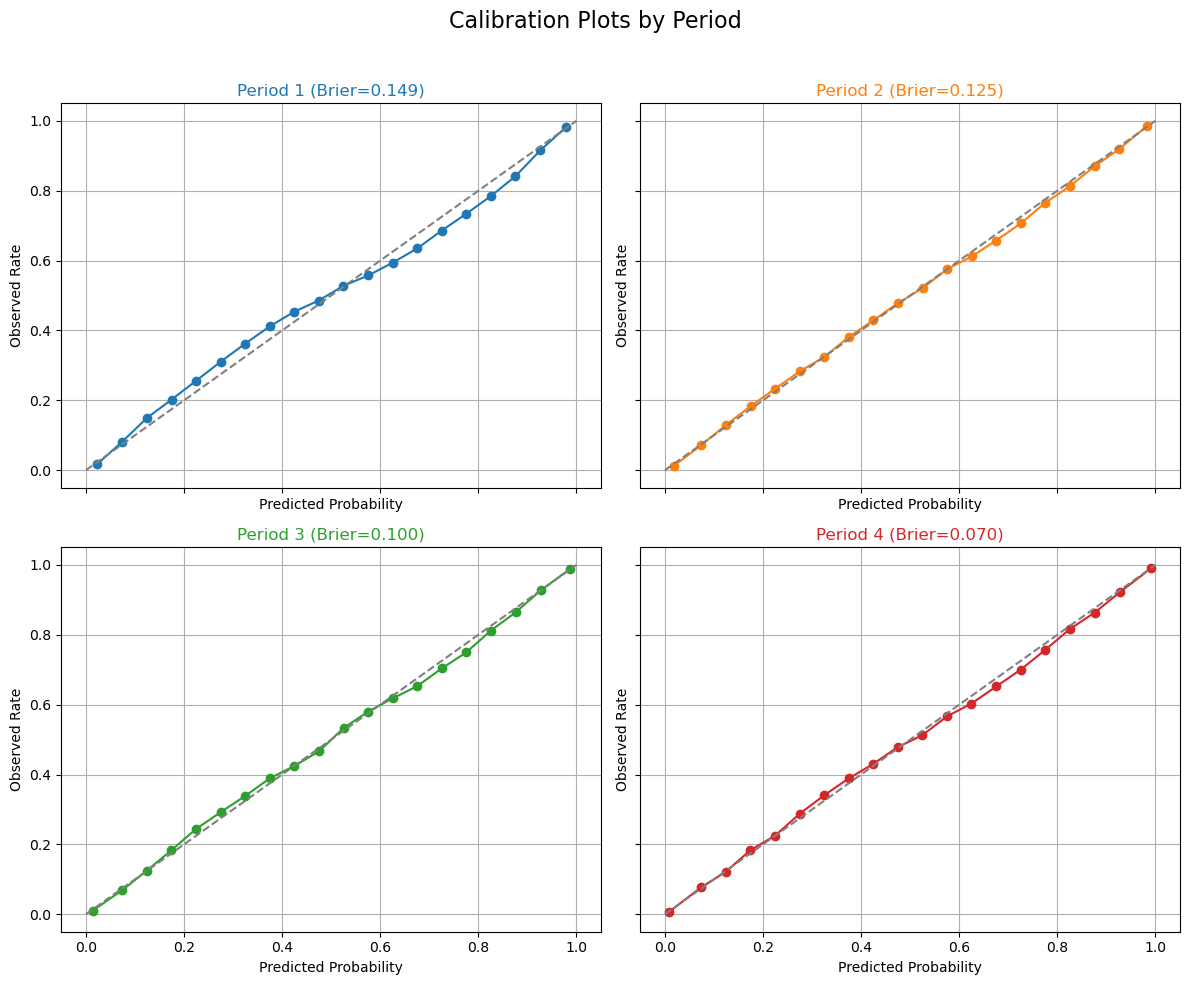

In [47]:
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np

def plot_calibration_subplots(df, proba_col, actual_col, period_col='period', bins=20):
    # Bin probabilities into equal-width bins
    df['proba_bin'] = pd.cut(
        df[proba_col],
        bins=np.linspace(0, 1, bins + 1),
        labels=False,
        include_lowest=True
    )

    # Group by both period and bin
    calibration = (
        df.groupby([period_col, 'proba_bin'])
          .agg(
              predicted_proba=(proba_col, 'mean'),
              actual_proba=(actual_col, 'mean'),
              count=(proba_col, 'size')
          )
          .reset_index()
    )

    periods = sorted(df[period_col].unique())
    n_periods = len(periods)

    # Assign colors for each period
    colors = plt.cm.tab10.colors  # 10 nice distinct colors
    color_map = {p: colors[i % len(colors)] for i, p in enumerate(periods)}

    fig, axes = plt.subplots(2, 2, figsize=(12, 10), sharex=True, sharey=True)
    axes = axes.flatten()

    for i, period in enumerate(periods):
        ax = axes[i]
        group = calibration[calibration[period_col] == period]

        # Compute Brier score for this period
        mask = df[period_col] == period
        brier = np.mean((df.loc[mask, proba_col] - df.loc[mask, actual_col]) ** 2)

        ax.plot(
            group['predicted_proba'],
            group['actual_proba'],
            marker='o',
            color=color_map[period],
            label=f'Period {period}'
        )
        ax.plot([0, 1], [0, 1], linestyle='--', color='gray')

        ax.set_title(f'Period {period} (Brier={brier:.3f})', color=color_map[period])
        ax.set_xlabel('Predicted Probability')
        ax.set_ylabel('Observed Rate')
        ax.grid(True)

    # Hide unused subplots if fewer than 4 periods
    for j in range(i + 1, len(axes)):
        fig.delaxes(axes[j])

    plt.suptitle('Calibration Plots by Period', fontsize=16)
    plt.tight_layout(rect=[0, 0, 1, 0.96])
    plt.show()

# Example usage
plot_calibration_subplots(df, proba_col='win_proba', actual_col='won', period_col='period', bins=20)


In [48]:
model_dir = join('..','..','inference', 'models', 'win_probability')
if not os.path.exists(model_dir):
    os.makedirs(model_dir)

model_path = os.path.join(model_dir, f"xgb_classifier.json")
final_model.save_model(model_path)

print(f"Saved model to the '{model_dir}' folder.")

Saved model to the '../../inference/models/win_probability' folder.
